### __Notebook to verify that looking at temperature amplitude ratio is interesting for a diffusive problem in the monodirectional case__ ###


In [146]:
#Necessary imports

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn as sk 
from pyheatmy import * 
from pyheatmy.time_series_multiperiodic import class_time_series_multiperiodic

from sklearn import linear_model
from pyheatmy.core import *
import scipy
import plot_regress_temperature as prt
import calc_pearson_coef as cpc


In [147]:
# On commence par créer un signal d'entrée grace à la classe time_series_multiperiodic, que l'on forcera dans la classe Synthetic_Molonari ensuite

T_riv = class_time_series_multiperiodic("multi_periodic")

# On regarde des variations de température sur une année, on définit une période journalière, et une période annuelle

"""Conditions limites"""
# Température de la rivière
T_riv_year_amp = 5 # °C, représente l'amplitude de variation de température annuelle
T_riv_offset = 12 + ZERO_CELSIUS # °C, représente l'offset commun de nos signaux de température
T_riv_day_amp = 5 # °C, représente l'amplitude de variation de température journalière
# Température de l'aquifère
T_aq_amp = 0
T_aq_offset = 12 + ZERO_CELSIUS
P_T_aq = -9999 # à mettre dans le init

P_T_riv_year = NDAYINYEAR * NSECINDAY # Période annuelle en mois
P_T_riv_day = NSECINDAY # Période journalière, en heures
t_debut = (2024, 4, 15, 8, 0, 0)  # (year, month, day, hour, minute, second)
t_fin = (2024, 4, 20, 8, 0, 0)
dt = int(NSECINHOUR / 4)  #On se place dans le cas d'un point de mesure toutes les quinze minutes (à moduler en fonction de l'intervale temporel considéré)

moinslog10IntrinK = 11
lambda_s = 2 # test cas purement advectif
rhos_cs = 4e6
range_of_minus_log_10_K = [10,11,12,13,14,15]  # The values we want to test

n = 0.1  # porosité
nb_cells=100 # nombre de cellules, une tous les 5 centimètres 
depth_sensors = [.1, .2, .3, .4]
Zbottom = 1
river_bed = 1.  # profondeur de la colonne en mètres
last_cell = int(9/10 * nb_cells)  # on écarte les dernières valeurs pour éviter les effets de bord
depth_cells = np.linspace(0, river_bed, nb_cells)

# Pression différentielle
dH_amp = 0
dH_offset = 0.1  # m
P_dh = -9999 #14*24*4*dt

# Bruit de mesure
sigma_meas_P = 0.001
sigma_meas_T = 0.1

name ="Couche en sable"

In [148]:
#Ensuite, on commence par créer un objet synthetic_MOLONARI pour pouvoir utiliser ses méthodes (et en particulier accéder à son générateur de dates)

"""Reprise du code de dmo_genData pour créer un objet synthetic_MOLONARI"""
# un dictionnaire qui facilite le paramétrage avec des variables globales définies plus haut
time_series_dict_user1 = {
    "offset":.0,
    "depth_sensors":depth_sensors,
	"param_time_dates": [t_debut, t_fin, dt], 
    "param_dH_signal": [dH_amp, P_dh, dH_offset], #En vrai y aura une 4e valeur ici mais ca prendra en charge pareil
	"param_T_riv_signal": [T_riv_day_amp, P_T_riv_day, T_riv_offset],
    "param_T_aq_signal": [T_aq_amp, P_T_aq, T_aq_offset],
    "sigma_meas_P": sigma_meas_P,
    "sigma_meas_T": sigma_meas_T, #float
    "verbose": False
}
# instanciation du simulateur de données
emu_observ_test_user1 = synthetic_MOLONARI.from_dict(time_series_dict_user1)
# définition de la liste de dates
Dates = emu_observ_test_user1._dates

#On utilise le jeu de date précédent pour créer un signal de température multipériodique 
# signal multipériodique
T_riv.create_multiperiodic_signal([T_riv_year_amp, T_riv_day_amp], [[P_T_riv_year, 's'], [P_T_riv_day, 's']], emu_observ_test_user1._dates, dt,
                                   offset=T_riv_offset, verbose = False)


In [149]:
#On force la variable T_riv dans l'objet emu_observ_test_user1

emu_observ_test_user1._T_riv = T_riv.multi_periodic[1][:]

#Puis on applique les méthodes _generate_Shaft_Temp_series et _generate_perturb_Shaft_Temp_series pour changer les valeurs dépendante du nouveau T_riv

emu_observ_test_user1._generate_Shaft_Temp_series(verbose = False)
emu_observ_test_user1._generate_perturb_Shaft_Temp_series()
emu_observ_test_user1._generate_perturb_T_riv_dH_series()

In [150]:
#on génère un objet colonne à partir de l'objet emu_observ_test_user1
# modèle une couche
layers_list= layersListCreator([(name, Zbottom, moinslog10IntrinK, n, lambda_s, rhos_cs)])

print(f"Layers list: {layers_list}")

# on utilise les mesures générées précédemment dans les init "dH_measures" et "T_measures"
col_dict = {
	"river_bed": river_bed, 
    "depth_sensors": depth_sensors, #En vrai y aura une 4e valeur ici mais ca prendra en charge pareil
	"offset": .0,
    "dH_measures": emu_observ_test_user1._molonariP_data,
    "T_measures": emu_observ_test_user1._molonariT_data,
    "sigma_meas_P": sigma_meas_P,
    "sigma_meas_T": sigma_meas_T,
}
col = Column.from_dict(col_dict,verbose=False)

col._compute_solve_transi_multiple_layers(layers_list, nb_cells, verbose=False)

Layers list: [Couche en sable : ends at 1 m. Parametres(moinslog10IntrinK=11, n=0.1, lambda_s=2, rhos_cs=4000000.0)]


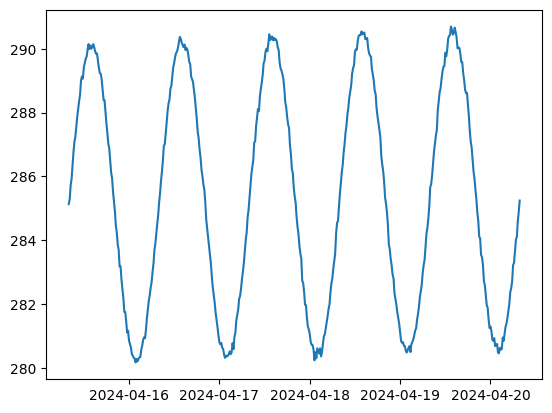

La matrice de température a pour shape : (100, 480), abscisse = température aux 20 cellules, ordonnée = température à chaque pas de temps


In [151]:
#On vérifie que les températures ont bien été modifiées dans l'objet column (en particulier que la température à profondeur nulle est bien celle de la rivière)

plt.plot(emu_observ_test_user1._dates, col._temperatures[0,:])
plt.show()

print(f"La matrice de température a pour shape : {col._temperatures.shape}, abscisse = température aux 20 cellules, ordonnée = température à chaque pas de temps")

In [152]:
#On définit une fonction pour pouvoir compiler en faisant varier la valeur de la charge (et donc le régime infiltration ou exfiltration vers la 
#rivière) ainsi que la valeur de la porosité (et donc le régime de diffusion de la chaleur - majoritairement diffusif ou advectif)

def profil_temperature(offset_H, moinslog10IntrinK, verbose = False): 
    time_series_dict_user1 = {
    "offset":.0,
    "depth_sensors": depth_sensors,
	"param_time_dates": [t_debut, t_fin, dt], 
    "param_dH_signal": [dH_amp, P_dh, offset_H], #En vrai y aura une 4e valeur ici mais ca prendra en charge pareil
	"param_T_riv_signal": [T_riv_day_amp, P_T_riv_day, T_riv_offset],
    "param_T_aq_signal": [T_aq_amp, P_T_aq, T_aq_offset],
    "sigma_meas_P": sigma_meas_P,
    "sigma_meas_T": sigma_meas_T, 
    "verbose" : verbose
}
    emu_observ_test_user1 = synthetic_MOLONARI.from_dict(time_series_dict_user1)
    
    T_riv.create_multiperiodic_signal([T_riv_year_amp, T_riv_day_amp], [[P_T_riv_year, 's'], [P_T_riv_day, 's']], emu_observ_test_user1._dates, dt,
                                   offset=T_riv_offset, verbose = False)
    
    emu_observ_test_user1._T_riv = T_riv.multi_periodic[1][:]

    emu_observ_test_user1._generate_Shaft_Temp_series(verbose = False)
    emu_observ_test_user1._generate_perturb_Shaft_Temp_series()
    emu_observ_test_user1._generate_perturb_T_riv_dH_series()

    # modèle une couche
    layers_list= layersListCreator([(name, Zbottom, moinslog10IntrinK, n, lambda_s, rhos_cs)])

    # print(f"Layers list: {layers_list}")  # dans verbose

    # on utilise les mesures générées précédemment dans les init "dH_measures" et "T_measures"
    col_dict = {
        "river_bed": river_bed, 
        "depth_sensors": depth_sensors, #En vrai y aura une 4e valeur ici mais ca prendra en charge pareil
        "offset": .0,
        "dH_measures": emu_observ_test_user1._molonariP_data,
        "T_measures": emu_observ_test_user1._molonariT_data,
        "sigma_meas_P": sigma_meas_P,
        "sigma_meas_T": sigma_meas_T,
    }
    col = Column.from_dict(col_dict,verbose=False)
    col._compute_solve_transi_multiple_layers(layers_list, nb_cells, verbose=False)
    return col._temperatures


Avec - log(k) = 11 : 


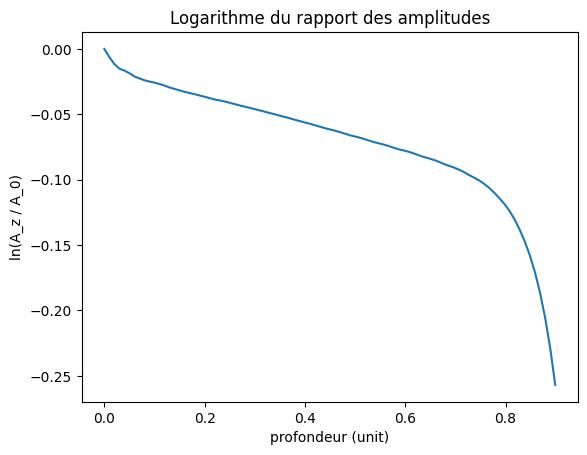

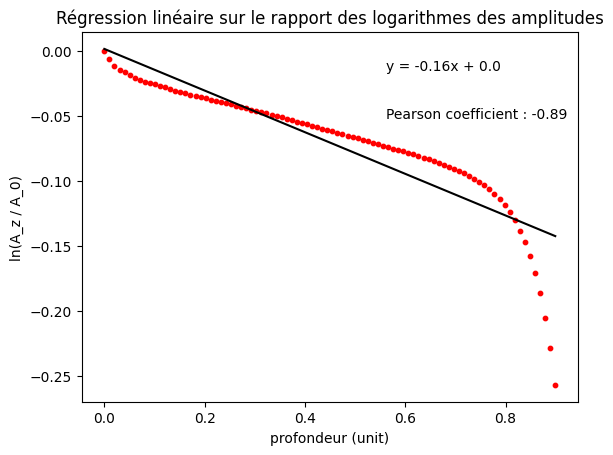

In [153]:
# On trace la température en fonction de la profondeur pour ce jour
# Il faudrait considérer une période particulière. Ici, on trace sur toute la durée mesurée

print("Avec - log(k) = " + str(moinslog10IntrinK) + ' : ')
profil_temp = profil_temperature(dH_offset, moinslog10IntrinK)[:last_cell,:]
prt.plot_ln_amp(depth_cells[0:last_cell], np.transpose(profil_temp))
prt.plot_linear_regression(depth_cells[0:last_cell], np.transpose(profil_temp))

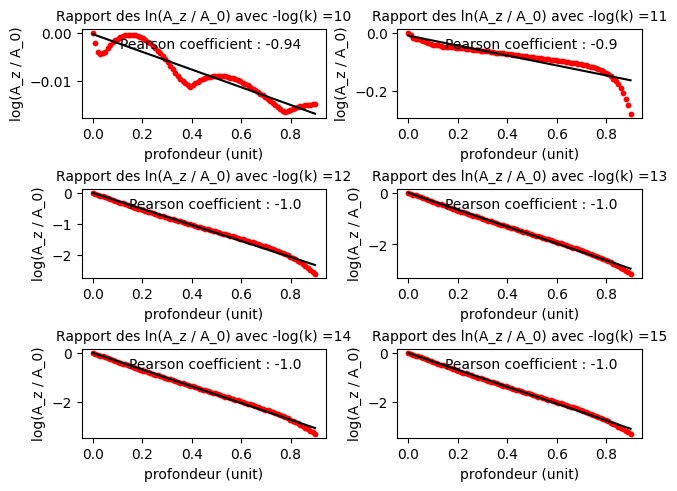

In [154]:
# Plot for different values of K
def plot_for_several_Kvalues(list_of_mlog_K_values):
    T_list = []
    for l in list_of_mlog_K_values:
        T = profil_temperature(dH_offset, l, verbose = False)
        T = T[0:last_cell,:]
        T_list.append(np.transpose(T))

    prt.plot_mosaic(depth_cells[0:last_cell], T_list, list_of_mlog_K_values)

plot_for_several_Kvalues(range_of_minus_log_10_K)

dt must be in seconds
dt must be in seconds
dt must be in seconds
dt must be in seconds
dt must be in seconds
dt must be in seconds
dt must be in seconds
dt must be in seconds
dt must be in seconds
dt must be in seconds
dt must be in seconds
dt must be in seconds


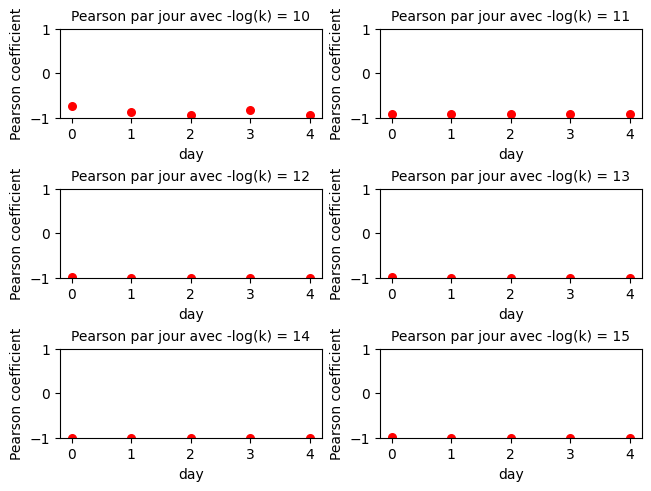

In [155]:
# plot pearson coefficients for different values of k

list_T = prt.list_k_T(range_of_minus_log_10_K)
prt.plot_mosaic_pearson(depth_cells[0:last_cell], list_T, range_of_minus_log_10_K, Dates, dt)

In [156]:
# url = 'data\Point035\point035_T_measures.csv' (try this path if the other one does not work)
url = '..\..\data\Point035\point035_T_measures.csv'
df = pd.read_csv(url)

df.columns = ['Date heure', 'T Sensor0', 'T Sensor1', 'T Sensor2', 'T Sensor3']

df.head()

,Date heure,T Sensor0,T Sensor1,T Sensor2,T Sensor3
0,07/12/16 11:00:00 AM,22.154,21.604,20.317,20.650
1,07/12/16 11:15:00 AM,26.500,27.038,23.737,21.819
2,07/12/16 11:30:00 AM,14.553,13.738,13.690,13.738
3,07/12/16 11:45:00 AM,14.768,14.002,13.954,14.002
4,07/12/16 12:00:00 PM,15.031,14.649,14.816,15.079


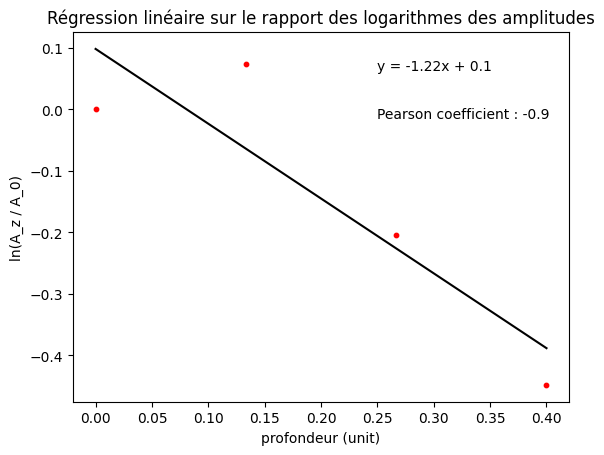

In [157]:
# Create the temperature matrix

T = [df['T Sensor' + str(i)] for i in range(4)]
T = np.array(T)
T = np.transpose(T)

depths = np.linspace(0, 0.4, 4)

prt.plot_linear_regression(depths, T)

dt must be in seconds
dt must be in seconds
dt must be in seconds


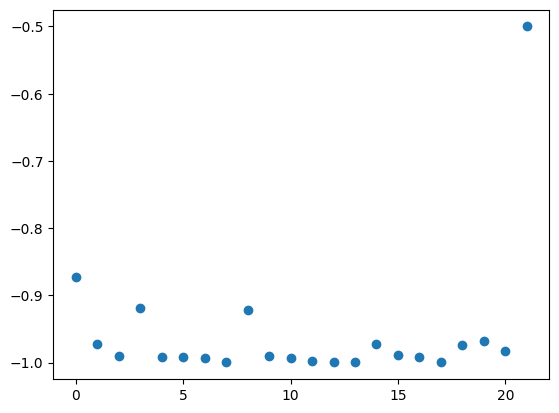

In [158]:
Y = cpc.get_pearson_coef(depths, T, df['Date heure'], dt)
n_days = cpc.nb_days_in_period(df['Date heure'], dt)
n_days = np.arange(n_days)
X = n_days

plt.scatter(X, Y)
plt.show()
